In [1]:
%matplotlib inline
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from functools import reduce
import re
from os.path import exists
from adjustText import adjust_text
from venn import venn

In [2]:
## Read lables from the info.tsv file into a dictionary
file_name = 'ALL_info.tsv'
d_labels = {}
with open(file_name, 'r') as inf:
    for line in inf.readlines():
        lib = line.split()[0]
        sample = line.split()[1]
        bird = line.split()[2]
        tissue = line.split()[3]
        d_labels[lib] = (sample, bird, tissue)

In [3]:
## DESeq2 analysis!!
dir_path = '/Users/osipova/Documents/LabDocs/Bird_transcriptomics/Transcriptome_for_NectarGenomics/DESeq2_results_Kallisto/'

# tissue = 'pectoralis'
tissue = 'liver'

sp1='Annas_hummingbird'
sp2='common_swift'
file_name = 'deseq2_res.{}.{}.{}.tsv'.format(tissue, sp1, sp2)

file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')
df.head(3)

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,PFKL,11079.913947,7.998389,0.213586,37.448066,6.458083e-307,6.976667e-303
1,SIK3,115204.463167,7.746154,0.222390,34.831429,8.135823e-266,4.394565e-262
2,CA8,4731.605807,7.222484,0.267275,27.022626,8.014187e-161,2.885909e-157


In [4]:
## DESeq2 : combine all data together!
dir_path = '/Users/osipova/Documents/LabDocs/Bird_transcriptomics/Transcriptome_for_NectarGenomics/DESeq2_results_Kallisto/'

pairs = [('Annas_hummingbird', 'common_swift'),
         ('New_Holland_honeyeater', 'zebra_finch'),
         ('rainbow_lorikeet', 'cockatiel')]

tissues = ['heart', 'fat', 'liver', 'pectoralis', 'pancreas',
          'kidney', 'duodenum', 'proventriculus', 'tongue', 'palate']

top = 0.05
all_pairs_dfs = {}

for pair in pairs:
    deseq_dict = {}
    test_sp = pair[0]
    ref_sp = pair[1]
    
    ## Merge all tissue datasets
    for tissue in tissues:
        deseq_res_file = 'deseq2_res.{}.{}.{}.tsv'.format(tissue, test_sp, ref_sp)
        deseq_res_file_path = dir_path + deseq_res_file

        # check if file exists
        if exists(deseq_res_file_path):
            df_f = pd.read_csv(glob(deseq_res_file_path)[0], sep='\t')

            ## Assign distance values and do ranking based on them
            df_f['log10padj'] = - np.log10(df_f['padj'])
            fc = df_f['log2FoldChange']
            pval = df_f['log10padj']
            df_f['distance'] = np.sign(fc) * np.sqrt(fc ** 2 + pval ** 2)
            df_f['rank_dist'] = df_f['distance'].rank()
            t_up = max(df_f['rank_dist']) * (1 - top)
            t_down = max(df_f['rank_dist']) * top
            ## Get top and bottom X% genes
            up_df_f = df_f[df_f['rank_dist'] >= t_up]
            down_df_f = df_f[df_f['rank_dist'] <= t_down]
            
            deseq_dict[tissue] = (df_f, up_df_f, down_df_f)
            all_pairs_dfs[test_sp] = (deseq_dict)

## [0] - ALLgenes; [1] - UP genes; [2] - DOWN genes
all_pairs_dfs['New_Holland_honeyeater']['liver'][1].head()

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log10padj,distance,rank_dist
0,DENND5B,2552.737168,6.714020,0.323750,20.738268,1.564576e-95,1.689586e-91,90.772220,91.020184,10799.0
2,GCNT7,903.658118,8.924514,0.472027,18.906785,1.002871e-79,3.610002e-76,75.442493,75.968524,10798.0
6,SLC15A1,542.268594,9.165077,0.603266,15.192421,3.969829e-52,6.124312e-49,48.212943,49.076333,10797.0
7,H1F0,8109.387382,5.705878,0.378701,15.066975,2.670643e-51,3.605035e-48,47.443091,47.784975,10796.0
8,ABCC2,4515.313616,6.207828,0.412996,15.031217,4.585009e-51,5.501501e-48,47.259519,47.665493,10795.0


In [5]:
all_pairs_dfs['New_Holland_honeyeater']['liver'][2].shape

(539, 10)

In [8]:
glut_num = ['1', '2', '5', '6', '7', '8', '9', '10', '11', '11L1', '12', '13', '14']
gluts = ['SLC2A{}'.format(i) for i in glut_num] + ['SLC5A1', 'SLC5A9']

gluc_metab_genes = ['HK1', 'HK2', 'HK3', 'HKDC1', 'GPI', 'PFKL',  'PFKP', 'PFKFB2', 
         'ALDOB', 'ALDOC', 'TPI1',  'PGAM1', 'PGAM5', 'ENO1', 'ENO2', 'ENO4',
         'PDHA1', 'PDHB', 'PDHX', 'LDHA', 'LDHB',
         'PCK1', 'FBP1', 'FBP2', 'G6PC', 'G6PC2', 'GYS2', 'GBE1', 'MLXIPL', 'MLX']

essent_pack1 = ['HK2', 'AMY1A', 'SI', 'SLC5A1', 'TAS1R1', 'TAS1R3', 'LCT']
essent_pack2 = ['SGCD', 'MYOCD', 'MYOF', 'MANBA', 'GCAT', 'GLB1L2', 'DMD', 'CNMD', 'CHST4', 'ASPG', 'B3GALNT1']
essent_pack3 = ['ANK2', 'ANO1', 'JADE1', 'FANCM', 'FAT1', 'FAT4', 'GRIP1', 'GRIP2', 'SNX19', 'HK1', 'HK2',
                'HK3', 'HKDC1', 'GRIK1', 'GRIK3', 'GRIK4', 'HYAL1', 'HYAL2']
essent_pack4 = ['B3GALT1', 'B4GALT5', 'B3GALNT1', 'ACAT1', 'ACSS1', 'ASPG', 'FH', 'GCSH', 'SORD',
                'MDH2', 'MLYCD', 'ALDH4A1', 'ALDH5A1', 'ALDH6A1', 'GOT1', 'GOT2', 'MCCC1', 'MCCC2']

essent_pack5 = ['ACAT1', 'ACOT8', 'ACOX2', 'ACSBG1', 'ACSL4', 'ACSS1', 'ACSS3', 'ALDH4A1', 'ALDH5A1',
                'ALDH6A1', 'ALDOB', 'ALDOC', 'AMT', 'ASPG', 'ASRGL1', 'BCKDHB', 'CDO1', 'CHDH', 'CHST10',
                'CKMT2', 'CPM', 'CROT', 'DECR2', 'ECHDC1', 'FADS1', 'FH', 'GCAT', 'GCSH', 'GOT1', 
                'GOT2', 'GYG2', 'HIBADH', 'HIBH', 'IVD', 'MCCC1', 'MCCC2', 'MDH2', 'ME1', 'MLYCD', 'NIT2',
                'OAT', 'PCCA', 'PDK1', 'PGM2', 'PLCE1', 'PRKX', 'SERP1', 'SLC25A1', 'SORD', 'SUCLG2', 'TPI1']
essent_pack6 = ['APOBEC2', 'CASZ1', 'COL13A1', 'PRDM16', 'KCNQ1', 'TRIM63', 'TPM4', 'AGTRAP', 'ASIC2', 
                'EDIL3', 'SLC22A18', 'EMP2', 'SLC30A2', 'NEUROG3', 'FOXL1', 'HNF1B', 'ONECUT1', 'TBX2', 
                'GMDS', 'ACACB', 'AGPAT2', 'LMF1', 'MVK', 'ACSF3', 'KYNU', 'MMAB', 'MVD', 'PERM1', 'SCL8B1']
genes_essent = essent_pack1 + essent_pack2 + essent_pack3 + essent_pack4 + essent_pack5 + \
            essent_pack6 + gluts + gluc_metab_genes

In [6]:
df = all_pairs_dfs['New_Holland_honeyeater']['liver'][0]
df.sample(10)

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log10padj,distance,rank_dist
5690,EDF1,5124.091384,0.514695,0.306441,1.679591,9.303698e-02,1.765430e-01,0.753149,0.912220,7672.0
3230,AKAP7,779.682267,1.456479,0.503407,2.893247,3.812817e-03,1.274069e-02,1.894807,2.389901,9179.0
5512,ABCA1,4957.337304,-0.784814,0.449251,-1.746940,8.064781e-02,1.579749e-01,0.801412,-1.121692,3750.0
2127,METAP2,1279.090146,1.075123,0.289470,3.714114,2.039171e-04,1.034822e-03,2.985135,3.172841,9641.0
557,ABHD2,1304.805342,-2.404796,0.387007,-6.213827,5.170957e-10,1.000738e-08,7.999680,-8.353318,398.0
5673,EAPP,252.737306,0.593476,0.352131,1.685384,9.191460e-02,1.749358e-01,0.757121,0.962001,7744.0
5147,PEX5,2004.337048,0.690619,0.362073,1.907402,5.646853e-02,1.184545e-01,0.926448,1.155535,8007.0
7581,DYTN,1.961493,-2.349906,2.417544,-0.972022,3.310396e-01,4.715412e-01,0.326480,-2.372477,2389.0
4386,EZH2,228.444659,-0.829488,0.365948,-2.266680,2.340979e-02,5.764893e-02,1.239209,-1.491204,3234.0
4981,SPAG17,3.035201,4.190233,2.109305,1.986547,4.697265e-02,1.018181e-01,0.992175,4.306096,10059.0


Annas_hummingbird	pectoralis	-1.13	1.02	0.0001373412879333	0.0001067880860135
New_Holland_honeyeater	pectoralis	-1.23	1.07	0.0052376890839378	0.149381731548526
rainbow_lorikeet	pectoralis	-1.02	1.01	0.0220626932255343	0.27978352540917
Annas_hummingbird	liver	-1.28	1.24	2.54945233374882e-05	2.94235989998089e-05
New_Holland_honeyeater	liver	-1.90	1.45	0.0066404159657053	0.180462975482323
rainbow_lorikeet	liver	-1.19	1.02	5.6426074467568e-06	0.167308967260204


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Annas_hummingbird	heart	-1.13	1.09	6.31931176842507e-08	5.53060845409809e-10
New_Holland_honeyeater	heart	-1.36	1.05	1.28332190733745e-05	0.0035857063688428
rainbow_lorikeet	heart	-1.20	1.05	0.0486625229899781	0.317948377402785
Annas_hummingbird	duodenum	-1.14	1.07	4.6566138540716593e-11	1.73739983456864e-05
New_Holland_honeyeater	duodenum	-1.79	1.67	0.0058082673165919	0.0056254982686573


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


rainbow_lorikeet	duodenum	-1.53	1.16	0.0497103504005694	0.392344565372902
Annas_hummingbird	palate	-1.01	1.00	0.0253828766195425	0.201709139670071
New_Holland_honeyeater	palate	-1.16	1.03	5.40105869994223e-05	0.0033046431509663
rainbow_lorikeet	palate	-1.06	1.01	0.0205184746004464	0.301098451428114


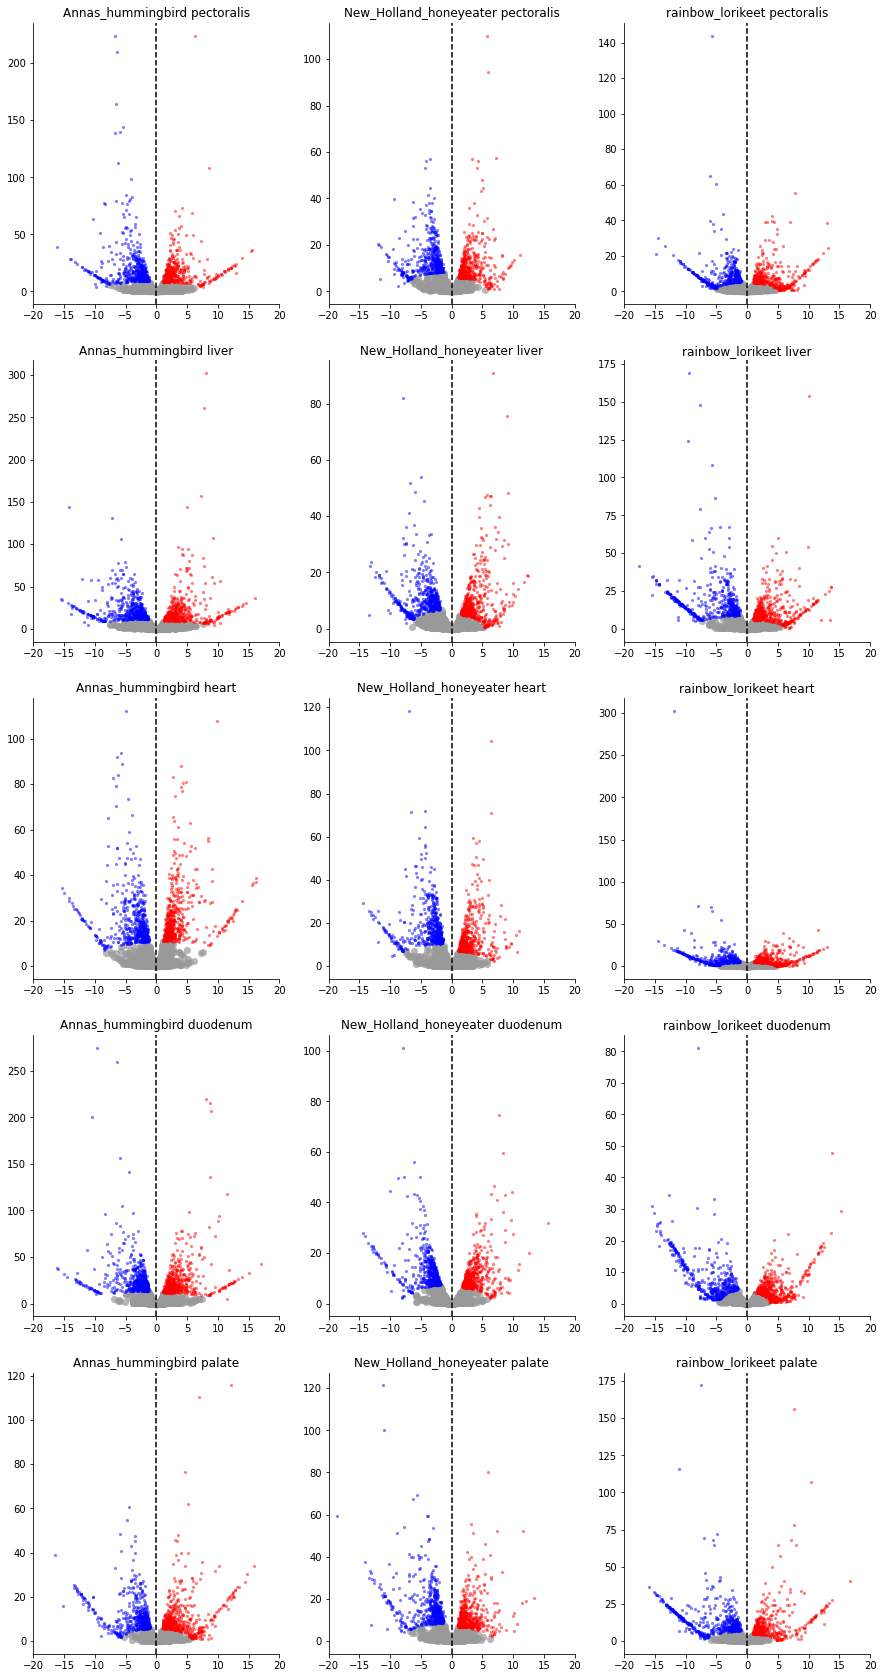

In [33]:
## Plot example volcano!

# N_genes = len(df.index)
top = 0.05

pval = 0.05
logFC = 1
fclim = 20
pvallim = 200

## To split y-axis:
# fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(5, 5))
# axes[1].set_ylim(0, plotlim + 10)
# axes[0].set_ylim(2*plotlim + 20, 175)

species = ['Annas_hummingbird', 'New_Holland_honeyeater', 'rainbow_lorikeet']
tissues = ['pectoralis', 'liver', 'heart', 'duodenum', 'palate']
N_sp = len(species)
N_tis = len(tissues)

fig, axes = plt.subplots(N_tis, N_sp, figsize=(3*5, 6*5))

for i in range(N_tis):
    for j in range(N_sp):
        t = tissues[i]
        sp = species[j]

        df = all_pairs_dfs[sp][t][0]
        genes = df['gene']
        df_f = df[df['gene'].isin(genes)]
        df_f = df_f.dropna()
        df_f['log2baseMean'] = np.log2(df_f['baseMean'])
        df_f['log10padj'] = - np.log10(df_f['padj'])
        fc = df_f['log2FoldChange']
        pval = df_f['log10padj']
        df_f['distance'] = np.sign(fc) * np.sqrt(fc ** 2 + pval ** 2)

        ## Do ranking based on distance values
        df_f['rank_dist'] = df_f['distance'].rank()
        t_up = max(df_f['rank_dist']) * (1 - top)
        t_down = max(df_f['rank_dist']) * top
       
        up_df_f = df_f[(df_f['rank_dist'] >= t_up) & (df_f['padj'] < pval) & (df_f['log2FoldChange'] > logFC)]
        down_df_f = df_f[(df_f['rank_dist'] <= t_down) & (df_f['padj']<0.05) & (df_f['log2FoldChange']< -logFC)]
        
        df_low_dist = df_f[(df_f['rank_dist'] > t_down) & (df_f['rank_dist'] < t_up)]

        ## Output general stats
        print('{}\t{}\t{:.2f}\t{:.2f}\t{}\t{}'.format(
                sp, t,
                max(down_df_f['log2FoldChange']),
                min(up_df_f['log2FoldChange']),
                max(down_df_f['padj']),
                max(up_df_f['padj']),
                ))
        
        axi = axes[i, j]
        sns.scatterplot(ax=axi, data=df_low_dist.sample(1000), y='log10padj', x='log2FoldChange', color='#999999', linewidth=0, s=50, alpha=0.7)
        sns.scatterplot(ax=axi, data=up_df_f, y='log10padj', x='log2FoldChange', color='red', linewidth=0, s=10, alpha=0.5)
        sns.scatterplot(ax=axi, data=down_df_f, y='log10padj', x='log2FoldChange', color='blue', linewidth=0, s=10, alpha=0.5)
        axi.axvline(0, color='k', ls='--')
        axi.set_xlim(-fclim, fclim)
#         axi.set_ylim(0, pvallim)
        axi.set_xlabel('')
        axi.set_ylabel('')
#         axi.set_yticks([0, 50, 100, 150, 200])
#         axi.set_yticklabels([0, 50, 100, 150, 200])
        axi.set_title('{} {}'.format(sp, t))

        if sp == 'Annas_hummingbird':
            dist = 15
        else:
            dist = 10
        
#         labels = []
#         # label cool candidates in down-reg genes
#         for x, y, g, d in zip(down_df_f['log2FoldChange'], down_df_f['log10padj'], down_df_f['gene'], down_df_f['distance']):
#             if (g in genes_essent) and (d < -dist):
#                 labels.append(axi.text(x=x, y=y, s=g, color='blue'))
#         # label cool candidates in up-reg genes
#         for x, y, g, d in zip(up_df_f['log2FoldChange'], up_df_f['log10padj'], up_df_f['gene'], up_df_f['distance']):
#             if (g in genes_essent) and (d > dist):
#                 labels.append(axi.text(x=x, y=y, s=g, color='red', alpha=0.5))
#         adjust_text(labels)

# texts = [plt.text(D.PC1.loc[lib], D.PC2.loc[lib], d_labels[lib][1]) for lib in select_lib]
# adjust_text(texts)
sns.despine(left=False, bottom=False, right=True, top=True)

pdf_name = 'volcano.all_3_species.5_tissues_deseq.labeled.adjusted.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


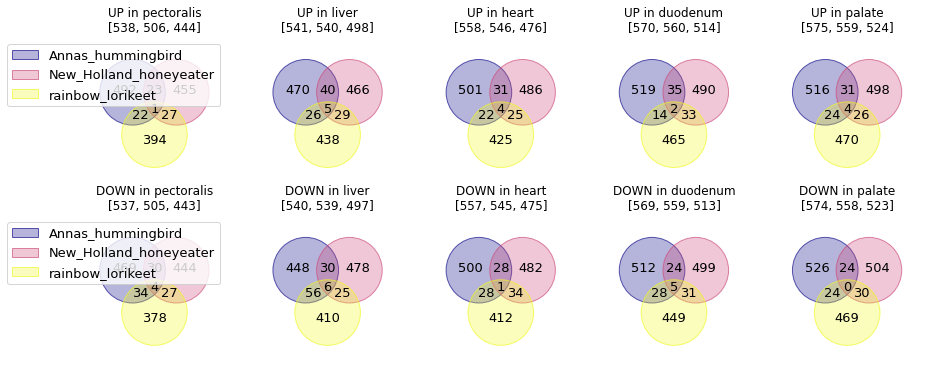

In [40]:
## Do Venns
species = ['Annas_hummingbird', 'New_Holland_honeyeater', 'rainbow_lorikeet']
tissues = ['pectoralis', 'liver', 'heart', 'duodenum', 'palate']
directions = ['UP', 'DOWN']
N_sp = len(species)
N_tis = len(tissues)
N_d = len(directions)

fig, axes = plt.subplots(N_d, N_tis, figsize=(3*N_tis, 3*N_d))

for i in range(N_tis):
    for j in range(N_d):
        t = tissues[i]
        d = directions[j]
        tissue_genes = {}

        total = []
        for sp in species:
            direction_genes = all_pairs_dfs[sp][t][j + 1]['gene']
            tissue_genes[sp] = set(direction_genes)
            total.append(len(tissue_genes[sp]))
        axi = axes[j, i]
        venn(tissue_genes, cmap='plasma', alpha=0.3, ax=axi)
        axi.set_title('{} in {}\n{}'.format(d, t, total))
        if i != 0:
            axi.legend(frameon=False)

pdf_name = 'venns.DGE.5_tissues_deseq.correceted.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')


In [10]:
all_pairs_dfs['New_Holland_honeyeater']['liver'][0].shape

(11333, 10)

In [35]:
## Write UP & DOWN gene lists to files
for sp in all_pairs_dfs:
    for tissue in all_pairs_dfs[sp]:
        up_out_file = 'new.up.{}.{}.top_{}.txt'.format(sp, tissue, top)
        down_out_file = 'new.down.{}.{}.top_{}.txt'.format(sp, tissue, top)
        up_df = all_pairs_dfs[sp][tissue][1]
        down_df = all_pairs_dfs[sp][tissue][2]
        
#         sns.histplot(up_df['log2FoldChange'])
        
        with open(up_out_file, 'w') as ouf:
            ouf.write('\n'.join(up_df['gene']))
        with open(down_out_file, 'w') as ouf:
            ouf.write('\n'.join(down_df['gene']))

In [32]:
sp = 'Annas_hummingbird'
temp_df = all_pairs_dfs[sp][tissue][1]
temp_df[temp_df['padj'] > 0.05]

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log10padj,distance,rank_dist
4533,OCM2,1942.073157,7.457268,3.268971,2.281228,0.022535,0.057148,1.243002,7.560152,11146.0
4534,CACNA2D3,45.486060,8.913054,3.907704,2.280893,0.022555,0.057185,1.242716,8.999271,11254.0
4601,reg_16264,1471.739356,6.004343,2.662469,2.255178,0.024122,0.060269,1.219909,6.127015,10986.0
4854,EN2,137.831933,7.451339,3.455171,2.156576,0.031039,0.073486,1.133798,7.537105,11144.0
4893,VGLL2,31.059673,8.362587,3.908143,2.139785,0.032372,0.076057,1.118861,8.437103,11208.0
5381,FAM240A,207.910198,7.032932,3.651061,1.926271,0.054071,0.115494,0.937441,7.095135,11108.0
6271,CA3A,1858.973339,5.955350,3.726612,1.598060,0.110030,0.201709,0.695274,5.995799,10967.0


In [22]:
# df_f[(df_f['log2FoldChange'] < -18) | (df_f['log10padj'] > 100)]
# up_df_f[up_df_f['log10padj'] > 100]
down_df_f[down_df_f['log10padj'] > 100]
# down_df_f[down_df_f['log2FoldChange'] < -15]
# up_df_f[up_df_f['log2FoldChange'] > 15]

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log10padj,distance,rank_dist,log2baseMean
0,ADAMTS12,8090.933440,-11.072583,0.395664,-27.984829,2.485765e-172,2.578732e-168,167.588594,-167.953978,1.0,12.982090
2,FRMPD2,4883.534722,-8.122297,0.307419,-26.420920,7.879085e-154,2.724588e-150,149.564699,-149.785083,2.0,12.253710
3,PLGL,5253.226331,-5.399957,0.207149,-26.067984,8.414087e-150,2.182193e-146,145.661107,-145.761166,3.0,12.358988
4,GPATCH1,10302.031787,-8.418150,0.326543,-25.779612,1.501333e-146,3.114966e-143,142.506547,-142.754969,4.0,13.330641
5,NUDT9,13165.375576,-5.219546,0.205578,-25.389586,3.286666e-142,5.682646e-139,138.245449,-138.343948,5.0,13.684461
6,DEPTOR,1085.701449,-5.281018,0.208803,-25.291852,3.926655e-141,5.819303e-138,137.235129,-137.336702,6.0,10.084412
7,UQCRH,2575.540265,-5.122761,0.224420,-22.826642,2.493926e-115,3.233998e-112,111.490260,-111.607889,7.0,11.330659


TypeError: string indices must be integers

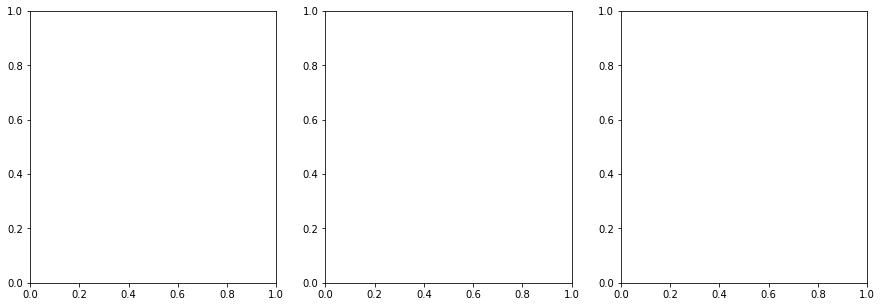

In [10]:
## Check mitoCarta genes you analyzed for FBP2 paper
file_name = '../Transcriptome_for_FBP2_paper/mitoCarta_human.genes.lst'
mitocarta_genes = []

with open(file_name, 'r') as inf:
    mitocarta_genes = [i.rstrip() for i in inf.readlines()]

    
pdf_name = 'ALL_pairs.{}_mitoCarta.deseq.volcano.pdf'.format(tissue)
pval = 0.001
fchange = 1
plotlim = 15
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

i = 0
for df in all_pairs_dfs:
        
    df_f = df[df['gene'].isin(mitocarta_genes)]
    df_f = df_f.dropna()
    df_f['log2baseMean'] = np.log2(df_f['baseMean'])
    df_f['log10padj'] = - np.log10(df_f['padj'])
    up_df_f = df_f[(df_f['padj'] < pval) & (df_f['log2FoldChange'] >= fchange)]
    down_df_f = df_f[(df_f['padj'] < pval) & (df_f['log2FoldChange'] <= -fchange)]

    sns.scatterplot(ax=axes[i], data=df_f, y='log10padj', x='log2FoldChange', color='k', linewidth=0, s=60, alpha=0.2)
    sns.scatterplot(ax=axes[i], data=up_df_f, y='log10padj', x='log2FoldChange', color='red', linewidth=0, s=60, alpha=0.3)
    sns.scatterplot(ax=axes[i], data=down_df_f, y='log10padj', x='log2FoldChange', color='blue', linewidth=0, s=60, alpha=0.3)
    axes[i].axvline(0, color='k', ls='--')
    axes[i].set_xlim(-plotlim, plotlim)

    axes[i].set_xlabel('log2 fold change')
    axes[i].set_ylabel('log10 p-value corrected')
    axes[i].set_title('  vs  '.join(list(pairs[i])))
    i += 1
    
# fig.savefig(pdf_name, bbox_inches='tight')

In [9]:
up_df_f[up_df_f['log10padj'] > 20]

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log2baseMean,log10padj


In [32]:
df_f.shape

(628, 9)

In [ ]:
### Intentionally left blank

In [5]:
def groupby_gene(d):
    g_d = d[['Gene', 'Name', 'EffectiveLength']].groupby(['Gene']).agg(['mean', 'std'])
    g_d.columns=g_d.columns.map('_'.join)
    g_d=g_d.reset_index()
    return g_d

In [10]:
## Get genes filtered for variation on effective genes langth
with open('same_len.one2ones_calAnn_apuApu.lst', 'r') as inf:
    same_len_genes = inf.read().split('\n')

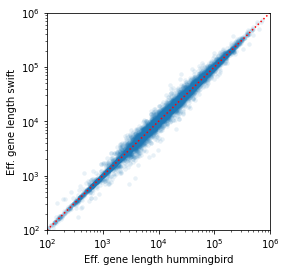

In [14]:
## Check correlation of effective gene lengths BEFORE and AFTER filtering
dir_path = '/Users/osipova/Documents/LabDocs/Bird_transcriptomics/Transcriptome_for_NectarGenomics/'
file_name_h = 'Salmon_quant_ALL_filt/L73700/filt.named_quant.sf'
file_name_s = 'Salmon_quant_ALL_filt/L73705/filt.named_quant.sf'


file_d_h = glob(dir_path + file_name_h)[0]
file_d_s = glob(dir_path + file_name_s)[0]
df_h = pd.read_csv(file_d_h, sep='\t')
df_s = pd.read_csv(file_d_s, sep='\t')

g_df_h = groupby_gene(df_h)
g_df_s = groupby_gene(df_s)

## merge these dataframes
df_h_s = pd.merge(g_df_h, g_df_s, on=['Gene'])
df_h_s.rename({'EffectiveLength_mean_x': 'mean_len_h',
               'EffectiveLength_mean_y': 'mean_len_s',
               'EffectiveLength_std_x': 'std_len_h',
               'EffectiveLength_std_y': 'std_len_y'}, axis=1, inplace=True)

fig, axes = plt.subplots(figsize=(4, 4))

filt_df_h_s = df_h_s[df_h_s['Gene'].isin(same_len_genes)]
# sns.scatterplot(ax=axes, data=df_h_s, x='mean_len_h', y='mean_len_s', alpha=.1, linewidth=0, s=20)
sns.scatterplot(ax=axes, data=filt_df_h_s, x='mean_len_h', y='mean_len_s', alpha=.1, linewidth=0, s=20)
axes.set(xlabel='Eff. gene length hummingbird', ylabel='Eff. gene length swift')
axes.set(xscale='log', yscale='log', xlim=(100, 1000000), ylim=(100, 1000000))
axes.plot([100, 1000000], [100, 1000000], c='r', ls=':')

# fig.savefig('filt.eff_length_corr_h_s.pdf', bbox_inches='tight')

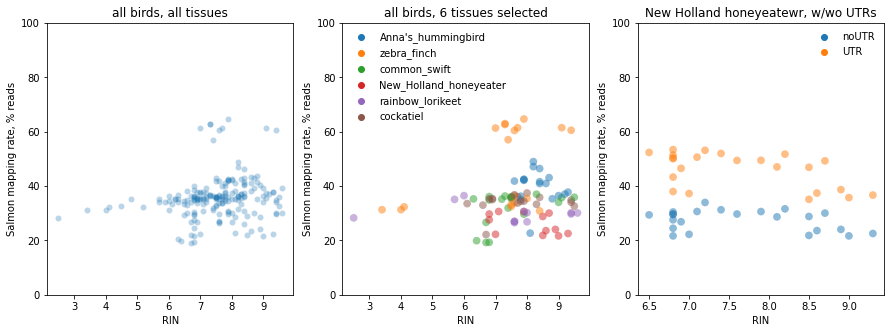

In [40]:
### Check correlation RIN vs mapping rate Salmon

dir_path = '/Users/osipova/Documents/LabDocs/Bird_transcriptomics/Transcriptome_for_NectarGenomics/'
file_name = 'info_RIN.all.tsv'

file_d = glob(dir_path + file_name)[0]
df_rin = pd.read_csv(file_d, sep='\t')

# label all samples with species and tissues
l_bird = [d_labels[l][1] for l in df_rin['library']]
l_tissue = [d_labels[l][2] for l in df_rin['library']]
df_rin['bird'] = l_bird
df_rin['tissue'] = l_tissue

the_tissues = ['liver', 'pectoralis', 'heart', 'fat', 'pancreas', 'duodenum']
df_rin_noutr = df_rin[df_rin['UTRs'] == 'noUTR']

# plot selected
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]

sns.scatterplot(ax=ax1, data=df_rin_noutr, x='RIN', y='mappingRate', alpha=.3, linewidth=0)
sns.scatterplot(ax=ax2, data=df_rin_noutr[df_rin_noutr['tissue'].isin(the_tissues)], 
                hue='bird', x='RIN', y='mappingRate', alpha=.5, linewidth=0, s=60)
# sns.scatterplot(ax=ax2, data=df_rin_noutr, hue='bird', x='RIN', y='mappingRate', alpha=.5, linewidth=0, s=60)
sns.scatterplot(ax=ax3, data=df_rin[df_rin['bird'] == 'New_Holland_honeyeater'], 
                hue='UTRs', x='RIN', y='mappingRate', alpha=.5, linewidth=0, s=60)

ax1.set(ylim=(0, 100), ylabel='Salmon mapping rate, % reads')
ax2.set(ylim=(0, 100), ylabel='Salmon mapping rate, % reads')
ax3.set(ylim=(0, 100), ylabel='Salmon mapping rate, % reads')
ax1.set_title('all birds, all tissues')
ax2.set_title('all birds, 6 tissues selected')
ax3.set_title('New Holland honeyeatewr, w/wo UTRs')

ax2.legend(frameon=False)
ax3.legend(frameon=False)

# fig.savefig('mappingRate_RIN_correlation.pdf', bbox_inches='tight')

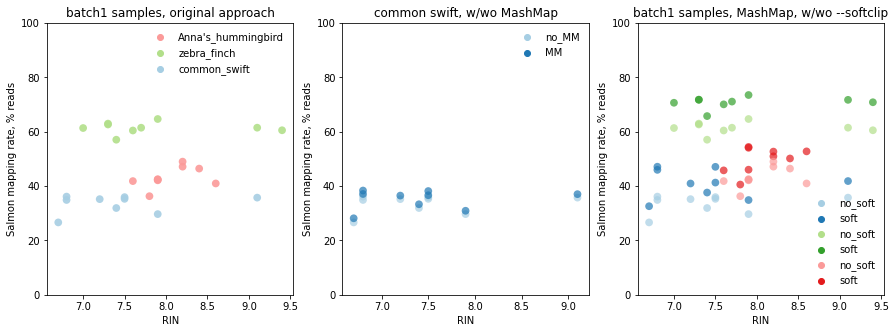

In [64]:
### Check how MsahMap alignment and --softclip influence mapping rate Salmon

dir_path = '/Users/osipova/Documents/LabDocs/Bird_transcriptomics/Transcriptome_for_NectarGenomics/'
file_name = 'info_RIN.MM_softclip.batch1.tsv'

file_d = glob(dir_path + file_name)[0]
df_rin = pd.read_csv(file_d, sep='\t')

# label all samples with species and tissues
l_bird = [d_labels[l][1] for l in df_rin['library']]
l_tissue = [d_labels[l][2] for l in df_rin['library']]
df_rin['bird'] = l_bird
df_rin['tissue'] = l_tissue


df_nomm_nosoft = df_rin[(df_rin['mashmap'] == 'no_MM') & (df_rin['softclip'] == 'no_soft')]
df_nosoft = df_rin[(df_rin.softclip == 'no_soft') & (df_nosoft['bird'] == 'common_swift')]
df_soft_mm = df_rin[(df_rin['mashmap'] != 'MM') | (df_rin['softclip'] != 'no_soft') ]

# plot selected
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]

# prepare color palettes
p = sns.color_palette('Paired', n_colors=6)
p0 = [p[i] for i in [4, 2, 0]]
p1 = [p[i] for i in [0, 1]]
p2 = [p[i] for i in [2, 3]]
p3 = [p[i] for i in [4, 5]]

# mapping rates, original approach
sns.set_palette(p0)
sns.scatterplot(ax=ax1, data=df_nomm_nosoft, x='RIN', y='mappingRate', 
                hue='bird', alpha=.9, linewidth=0, s=60)

# common swift, w/wo MashMap
sns.set_palette(p1)
sns.scatterplot(ax=ax2, data=df_nosoft, hue='mashmap', x='RIN', y='mappingRate', alpha=.7, linewidth=0, s=60)

# softclip for 3 birds
sns.set_palette(p1)
sns.scatterplot(ax=ax3, data=df_soft_mm[df_soft_mm['bird'] == 'common_swift'],
                hue='softclip', x='RIN', y='mappingRate', alpha=.7, linewidth=0, s=60)
sns.set_palette(p2)
sns.scatterplot(ax=ax3, data=df_soft_mm[df_soft_mm['bird'] == 'zebra_finch'],
                hue='softclip', x='RIN', y='mappingRate', alpha=.7, linewidth=0, s=60)
sns.set_palette(p3)
sns.scatterplot(ax=ax3, data=df_soft_mm[df_soft_mm['bird'] == 'Anna\'s_hummingbird'],
                hue='softclip', x='RIN', y='mappingRate', alpha=.7, linewidth=0, s=60)

ax1.set(ylim=(0, 100), ylabel='Salmon mapping rate, % reads')
ax2.set(ylim=(0, 100), ylabel='Salmon mapping rate, % reads')
ax3.set(ylim=(0, 100), ylabel='Salmon mapping rate, % reads')
ax1.set_title('batch1 samples, original approach')
ax2.set_title('common swift, w/wo MashMap')
ax3.set_title('batch1 samples, MashMap, w/wo --softclip')

ax1.legend(frameon=False)
ax2.legend(frameon=False)
ax3.legend(frameon=False)

# fig.savefig('mappingRate_RIN_MashMap_softclip.pdf', bbox_inches='tight')

In [20]:
## INTRAspecies DESeq2 analysis pectoralis VS liver

In [48]:
## DESeq2 : combine all data together!
dir_path = '/Users/osipova/Documents/LabDocs/Bird_transcriptomics/Transcriptome_for_NectarGenomics/Intra_species_DESeq2_results/'

pair = ('pectoralis', 'liver')
# pair = ('pectoralis', 'duodenum')

types = ['Annas_hummingbird', 'common_swift', 'New_Holland_honeyeater', 
         'zebra_finch', 'rainbow_lorikeet', 'cockatiel']

top = 0.02
all_pairs_dfs = {}

# for pair in pairs:
deseq_dict = {}
test = pair[0]
ref = pair[1]

## Merge all types datasets
for t in types:
    deseq_res_file = 'deseq2_res.{}.{}.{}.tsv'.format(t, test, ref)
    deseq_res_file_path = dir_path + deseq_res_file

    # check if file exists
    if exists(deseq_res_file_path):
        df_f = pd.read_csv(glob(deseq_res_file_path)[0], sep='\t')

        ## Assign distance values and do ranking based on them
        df_f['log10padj'] = - np.log10(df_f['padj'])
        fc = df_f['log2FoldChange']
        pval = df_f['log10padj']
        df_f['distance'] = np.sign(fc) * np.sqrt(fc ** 2 + pval ** 2)
        df_f['rank_dist'] = df_f['distance'].rank()
        t_up = max(df_f['rank_dist']) * (1 - top)
        t_down = max(df_f['rank_dist']) * top
        
        ## 1) Distance: get top and bottom X% genes
#         up_df_f = df_f[df_f['rank_dist'] >= t_up]
#         down_df_f = df_f[df_f['rank_dist'] <= t_down]
        
        ## 2) Significance: log2FC >= 2 & padj <= 0.001
        up_df_f = df_f[(df_f['log2FoldChange'] >= 2) & (df_f['padj'] <= .001)]
        down_df_f = df_f[(df_f['log2FoldChange'] <= -2) & (df_f['padj'] <= .001)]
        
        deseq_dict[t] = (df_f, up_df_f, down_df_f)
        all_pairs_dfs[test] = (deseq_dict)

## [0] - ALLgenes; [1] - UP genes; [2] - DOWN genes


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


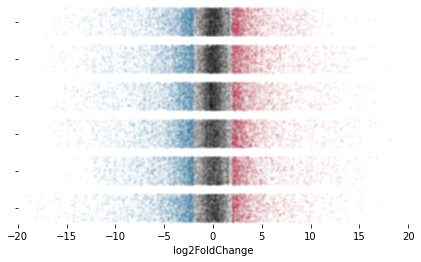

In [49]:
fig, axes = plt.subplots(6, 1, figsize=(7, 4))

i = 0
for t in types:
    dfi = deseq_dict[t][0]
    up_dfi = deseq_dict[t][1]
    down_dfi = deseq_dict[t][2]
    axi = axes[i]
    sns.stripplot(ax=axi, data=dfi, x='log2FoldChange', alpha=0.01, jitter=0.1, color='black', s=3)
    sns.stripplot(ax=axi, data=up_dfi, x='log2FoldChange', alpha=0.05, jitter=0.1, color='#ca0020', s=3)
    sns.stripplot(ax=axi, data=down_dfi, x='log2FoldChange', alpha=0.05, jitter=0.1, color='#0571b0', s=3)
#     axi.set(xlim=(-300, 300))
    axi.set(xlim=(-20, 20))
    if i != 5:
        axi.tick_params(bottom=False)
        axi.set(xticklabels=[])
        axi.set_ylabel('')
    i += 1
sns.despine(left=True, bottom=True, right=True)


pdf_name = 'all_sign_genes_liver_pect_6species.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

In [50]:
core_test_up = {}
core_ref_up = {}
for t in types:
    up = list(deseq_dict[t][1]['gene'])
    down = list(deseq_dict[t][2]['gene'])
    core_test_up[t] = up
    core_ref_up[t] = down

In [51]:
def intersect_filter_foreground(dict_of_lists, foreground, background):
    ## Returns elements in intersection of all lists 
    ## in foreground that are not in the background lists
    
    # get intersect FG
    if foreground == []:
        intersect_fg = []
    else:
        k_fg = foreground[0]
        intersect_fg = dict_of_lists[k_fg]
        for k in foreground:
            intersect_fg = list(set(intersect_fg) & set(dict_of_lists[k]))
    
    # get union BG
    if background == []:
        union_bg = []
    else:
        k_bg = background[0]
        union_bg = dict_of_lists[k_bg]
        for k in background:
            union_bg = union_bg + dict_of_lists[k]
    
    return list(set(intersect_fg) - set(union_bg))

In [52]:
## Get core and uniq genes
nectar = ['Annas_hummingbird', 'New_Holland_honeyeater', 'rainbow_lorikeet']
nonnectar = ['common_swift', 'zebra_finch', 'cockatiel']

core_ref_up_all = intersect_filter_foreground(core_ref_up, types, [])
core_test_up_all = intersect_filter_foreground(core_test_up, types, [])

print('number of core ref genes is {}'.format(len(core_ref_up_all)))
print('number of core testoralis genes is {}'.format(len(core_test_up_all)))

nectar_ref_up_dict = {}
nectar_test_up_dict = {}
nonnectar_ref_up_dict = {}
nonnectar_test_up_dict = {}
for n in nectar:
    nectar_ref_up_dict[n] = intersect_filter_foreground(core_ref_up, [n], nonnectar)
    nectar_test_up_dict[n] = intersect_filter_foreground(core_test_up, [n], nonnectar)
    print('{} has {} ref up genes that are not in nonnectar'.format(n, len(nectar_ref_up_dict[n])))
    print('{} has {} test up genes that are not in nonnectar'.format(n, len(nectar_test_up_dict[n])))
    
for n in nonnectar:
    nonnectar_ref_up_dict[n] = intersect_filter_foreground(core_ref_up, [n], nectar)
    nonnectar_test_up_dict[n] = intersect_filter_foreground(core_test_up, [n], nectar)
    print('{} has {} ref up genes that are not in nectar'.format(n, len(nonnectar_ref_up_dict[n])))
    print('{} has {} test up genes that are not in nectar'.format(n, len(nonnectar_test_up_dict[n])))

number of core ref genes is 288
number of core testoralis genes is 211
Annas_hummingbird has 375 ref up genes that are not in nonnectar
Annas_hummingbird has 330 test up genes that are not in nonnectar
New_Holland_honeyeater has 250 ref up genes that are not in nonnectar
New_Holland_honeyeater has 243 test up genes that are not in nonnectar
rainbow_lorikeet has 313 ref up genes that are not in nonnectar
rainbow_lorikeet has 253 test up genes that are not in nonnectar
common_swift has 388 ref up genes that are not in nectar
common_swift has 317 test up genes that are not in nectar
zebra_finch has 305 ref up genes that are not in nectar
zebra_finch has 261 test up genes that are not in nectar
cockatiel has 365 ref up genes that are not in nectar
cockatiel has 259 test up genes that are not in nectar


In [53]:
genes_essent = ['NDUFA4', 'NDUFA6', 'NDUFA8', 'NDUFA9', 'NDUFA12',
                'COX6A', 'COX7B', 'ATP5MF', 'ATP5PF', 'IDH3B', 'B4GALT2',
                'MRPL18', 'MRPL41', 'MRPL33', 'MRPL37', 'ETFA', 'ETFDH', 'MPI',
                'ABCD3', 'ABCD2', 'ACBD5', 'ADIPOR2', 'IVD', 'GBI', 'PNPLA3', 'ACSLH',
                'PLA2G7', 'PYGL', 'FA2H', 'CYP3A4', 'EHHAGH', 'PFKL', 'SLC35A5', 'INSIG2']

Annas_hummingbird
common_swift
New_Holland_honeyeater
zebra_finch
rainbow_lorikeet
cockatiel


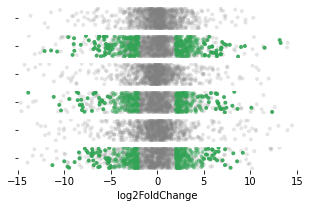

In [54]:
extremes_exp = {}

## Plot the same distributions but with only core genes
fig, axes = plt.subplots(6, 1, figsize=(5, 3))

i = 0
for t in types:
    print(t)
    dfi = deseq_dict[t][0].sample(n=1000, replace=False)
    up_dfi = deseq_dict[t][1].sample(n=600, replace=False)
    down_dfi = deseq_dict[t][2].sample(n=600, replace=False)
    
    core_up_dfi = up_dfi[up_dfi['gene'].isin(core_test_up_all)]
    core_down_dfi = down_dfi[down_dfi['gene'].isin(core_ref_up_all)]
    
    axi = axes[i]
    sns.stripplot(ax=axi, data=dfi, x='log2FoldChange', alpha=0.2, jitter=0.1, color='gray', s=4)
#     sns.stripplot(ax=axi, data=core_up_dfi, x='log2FoldChange', alpha=0.2, jitter=0.1, color='#ca0020', s=3)
#     sns.stripplot(ax=axi, data=core_down_dfi, x='log2FoldChange', alpha=0.2, jitter=0.1, color='#0571b0', s=3)
    
    if t in nonnectar:
        uniq_up_dfi = up_dfi[up_dfi['gene'].isin(nonnectar_test_up_dict[t])]
        uniq_down_dfi = down_dfi[down_dfi['gene'].isin(nonnectar_ref_up_dict[t])]
        
        # for visualisation, separate high and medium
        med_up_dfi = uniq_up_dfi[uniq_up_dfi['log2FoldChange'] <= 5]
        med_down_dfi = uniq_down_dfi[uniq_down_dfi['log2FoldChange'] >= -5]
        high_up = uniq_up_dfi[uniq_up_dfi['log2FoldChange'] > 5]
        high_down = uniq_down_dfi[uniq_down_dfi['log2FoldChange'] < -5]
        
        purple = '#a000c8'
        red = '#ca0020'
        blue = '#0571b0'
        green = '#31a354'
        sns.stripplot(ax=axi, data=med_up_dfi, x='log2FoldChange', alpha=0.5, jitter=0.1, color=green, s=4)
        sns.stripplot(ax=axi, data=med_down_dfi, x='log2FoldChange', alpha=0.5, jitter=0.1, color=green, s=4)
        sns.stripplot(ax=axi, data=high_up, x='log2FoldChange', alpha=0.9, jitter=0.1, color=green, s=4)
        sns.stripplot(ax=axi, data=high_down, x='log2FoldChange', alpha=0.9, jitter=0.1, color=green, s=4)
        
    
        extremes_exp[t] = [uniq_up_dfi[uniq_up_dfi['distance'] > 20]['gene'],
                           uniq_down_dfi[uniq_down_dfi['distance'] < -20]['gene']]        
    
        ## Print log foldChange for essential genes
        for g in genes_essent:
            if g in list(uniq_up_dfi['gene']):
                print('{} log2 FC: {}'.format(g, float(uniq_up_dfi[uniq_up_dfi['gene'] == g]['log2FoldChange'])))
            if g in list(uniq_down_dfi['gene']):
                print('{} log2 FC: {}'.format(g, float(uniq_down_dfi[uniq_down_dfi['gene'] == g]['log2FoldChange'])))
                
    axi.set(xlim=(-15, 15))
    if i != 5:
        axi.tick_params(bottom=False)
        axi.set(xticklabels=[])
        axi.set_xlabel('')
    i += 1
sns.despine(left=True, bottom=True, right=True)

# pdf_name = 'core_genes_ref_test_6species.pdf'
# pdf_name = 'uniq_ONLY.nonnectar_genes_pect_liver_6species.pdf'
pdf_name = 'green.compressed.uniq_ONLY.nonnectar_genes_pect_liver_6species.pdf'
# fig.savefig(pdf_name, format='pdf', bbox_inches='tight')

In [55]:
up_dfi.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log10padj,distance,rank_dist
579,HSPB3,191.710471,7.530963,0.667929,11.275102,1.741770e-29,3.203656e-28,27.494354,28.507103,10465.0
349,TBC1D4,282.973721,3.487265,0.257874,13.523110,1.142428e-41,3.482119e-40,39.458156,39.611957,10546.0
1403,CTGFL,49.967150,6.139684,0.826659,7.427104,1.110013e-13,8.434200e-13,12.073956,13.545336,10154.0
822,CDHR3,91.831582,4.849245,0.490700,9.882307,4.967609e-23,6.439180e-22,21.191169,21.738924,10362.0
480,TPI1,7365.445322,2.083411,0.173507,12.007636,3.239755e-33,7.185386e-32,31.143550,31.213159,10498.0


In [57]:
## Write these genes lists into files

# core genes
coreref = 'core_{}_genes.all.txt'.format(pair[1])
with open(coreref, 'w') as ouf:
    for g in core_ref_up_all:
        ouf.write(g + '\n')
        
coretest = 'core_{}_genes.all.txt'.format(pair[0])
with open(coretest, 'w') as ouf:
    for g in core_test_up_all:
        ouf.write(g + '\n')
        
# uniquely expressed nectar
for n in nectar:
    outref = 'up_{}_genes_{}_not_nonnectar.txt'.format(pair[1], n)
    outtest = 'up_{}_genes_{}_not_nonnectar.txt'.format(pair[0], n)
    with open(outref, 'w') as ouf:
        for g in nectar_ref_up_dict[n]:
            ouf.write(g + '\n')
    with open(outtest, 'w') as ouf:
        for g in nectar_test_up_dict[n]:
            ouf.write(g + '\n')

# uniquely expressed NONnectar           
for n in nonnectar:
    outref = 'up_{}_genes_{}_not_nectar.txt'.format(pair[1], n)
    outtest = 'up_{}_genes_{}_not_nectar.txt'.format(pair[0], n)
    with open(outref, 'w') as ouf:
        for g in nonnectar_ref_up_dict[n]:
            ouf.write(g + '\n')
    with open(outtest, 'w') as ouf:
        for g in nonnectar_test_up_dict[n]:

            ouf.write(g + '\n')

In [61]:
nonnectar

['common_swift', 'zebra_finch', 'cockatiel']

No handles with labels found to put in legend.
No handles with labels found to put in legend.


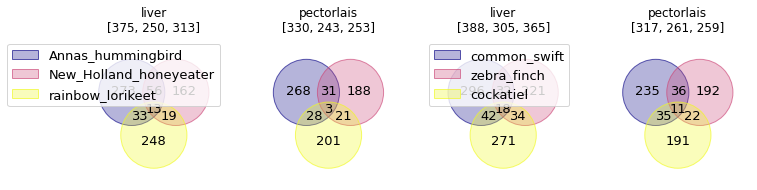

In [76]:
### Do Venns

bird_sets = [nectar_ref_up_dict, nectar_test_up_dict, nonnectar_ref_up_dict, nonnectar_test_up_dict]
bird_types = [nectar, nectar, nonnectar, nonnectar]
tissues = ['liver', 'pectorlais', 'liver', 'pectorlais']


fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axi = axes[i]
    bird_set = bird_sets[i]
    bird_type = bird_types[i]
    tissue = tissues[i]

    genes = {sp: set(bird_set[sp]) for sp in bird_type}
    venn(genes, cmap='plasma', alpha=0.3, ax=axi)
    
    total = [len(genes[sp]) for sp in bird_type]
    axi.set_title('{}\n{}'.format(tissue, total))
    if (i != 0) and (i != 2):
        axi.legend(frameon=False)

pdf_name = 'venns.intra_species.with_total.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')